# Here we compare the Results of ChatGPT against the manuell Results

In [68]:
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, auc, confusion_matrix, f1_score, 
    precision_recall_curve, precision_score, recall_score, roc_curve
)

import sklearn.metrics
from openpyxl import Workbook
from openpyxl.styles import Alignment, Font, PatternFill
from openpyxl.utils import get_column_letter as utils_get_column_letter
from openpyxl.worksheet.worksheet import Worksheet

from support_functions.excel_helper import (
    load_datasets_add_line_counter, prepaire_excel_data, save_to_excel
)
from support_functions.load_json_chatgpt_results import load_chat_gpt_results

### Loading the data from excel data

In [69]:
excel_data = prepaire_excel_data()
excel_data[excel_data['Project Number'] == "G03"].head(3)

,Project Number,Redundant Pairs,User Stories Texts,Total Redundancy Clause *,Corresponding USID 1,Corresponding USID 2,Main Part Redundancy Clause**,Benefit Part Redundancy Clause ***,Main Part Partial,Main Part Full,Benefit Partial,Benefit Full
1,G03,user_story_12_AND_user_story_39,"user_story_12: #g03# as a staff member, i want...",1,326,353,0,1,False,False,True,False
2,G03,user_story_17_AND_user_story_30,"user_story_17: #g03# as a staff member, i want...",1,331,344,0,1,False,False,True,False


### Loading ChatGPT results

In [70]:
directories_to_ignore:dict = ["annotations", "dependency_graph", "us_annotations_redundancy-model-gpt-3.5-turbo", "us_annotations_redundancy-model-gpt-4-turbo"]
chat_gpt_results: dict[str, dict[str, dict]] = load_chat_gpt_results(directories_to_ignore)
chat_gpt_result_keys: list[str] = list(chat_gpt_results.keys())
chat_gpt_result_json_keys = {
    outer_key: list(inner_dict.keys())
    for outer_key, inner_dict in chat_gpt_results.items()
}

### Analyse - TP, FP, TN, FN, Precision, Recall, F1 Score, Accuracy, Confusion Matrix, ROC Curve and AUC-ROC, Precision-Recall Curve and AUC-PR

- We check here if the Redundancy is at all detected and not the frequencies
- We check here for just for redundancy and not the difference between full and partial redundancy

#### Time Consulption Function

In [135]:
i = 0
try:
    while -1 < i:
        i += 1
except Exception as e:
    print(e) 

In [72]:
def calc_time_consumption(data) -> tuple[np.ndarray, np.ndarray, int, float]:
    total_time: int = 0
    single_total_time: int = 0
    avg_time: float = 0.0
    single_avg_time: float = 0.0
    requests: int = 0
    single_requests: int = 0
    total_elements = len(data.keys())
    cus_dtype_total = np.dtype([('key', np.str_, 20), ('time', np.uint64)])
    cus_dtype_avg = np.dtype([('key', np.str_, 20), ('avg_time', np.longfloat)])
    total_single_time_collection: np.ndarray = np.empty(total_elements, dtype=cus_dtype_total, order='C')
    total_single_avg_collection: np.ndarray = np.empty(total_elements, dtype=cus_dtype_avg, order='C')
    idx: int = 0
    out_of_bounce_checker: int = 0
    single_out_of_bounce_checker: int = 0
    for key in data.keys():
        single_total_time = single_avg_time = single_requests = single_out_of_bounce_checker = 0
        json_item = data[key]
        for item in json_item:
            total_time += item['elipsedTimeNs']
            single_total_time += item['elipsedTimeNs']
            if single_out_of_bounce_checker >= single_total_time:
                raise ValueError(f"Out of bounce for {key}")
            elif out_of_bounce_checker >= total_time:
                raise ValueError(f"Out of bounce for total time")
            else:
                out_of_bounce_checker = total_time
                single_out_of_bounce_checker = single_total_time
            requests += 1
            single_requests += 1
        single_avg_time = single_total_time / single_requests if single_requests > 0 else 0.0
        total_single_time_collection[idx] = (key.rstrip(".json"), single_total_time)
        total_single_avg_collection[idx] = (key.rstrip(".json"), single_avg_time)
        idx += 1
    avg_time = total_time / requests if requests > 0 else 0.0
    return total_single_time_collection, total_single_avg_collection, total_time, avg_time

#### Performance

In [73]:
# Define an epsilon value to prevent division by zero
# Based on IEEE 754 double-precision binary floating-point format (binary64)
EPSILON = sys.float_info.min

In [74]:

def calc_redundancy(local_ground_truth: pd.DataFrame, data: dict[list[dict]], main_part: bool) -> tuple[np.array, np.array, int, int, int, int]:
    keys_for_eval = [
        'relatedStories',  # Always included
        'redundantMainPart' if main_part else 'redundantBenefit',
        'mainPartRedundancies' if main_part else 'benefitRedundancies',
        6 if main_part else 7
    ]
    
    entries: int = 0
    for key in data.keys():
        json_item = data[key]
        for item in json_item:
            entries += 1
    truth: np.array = np.zeros(entries, dtype=int)
    predicted: np.array = np.zeros(entries, dtype=int)
    tp, fp, tn, fn = 0, 0, 0, 0

    truth_redundant: bool = False
    predicted_redundant:bool = False
    uid1: int = -1
    uid2: int = -1
    min_length: int = -1
    entries_in_filtered_row: int = -1
    ENTRY_IN_GROUND_TRUTH: int = 1
    ENTRY_NOT_IN_GROUND_TRUTH: int = 0
    
    # We assume here that the .json-Files have always all posible pairs n(n-1)/2
    idx_np_array: int = 0
    for key in data.keys():
        json_item = data[key]
        for item in json_item:
            try:
                uid1, uid2 = item[keys_for_eval[0]]
            except (ValueError, KeyError) as e:
                print(f"Error extracting UIDs from item: {item}, key: {key}")
                raise e
            filtered_rows = local_ground_truth[(local_ground_truth['Corresponding USID 1'].astype(int) == uid1) 
                                       & (local_ground_truth['Corresponding USID 2'].astype(int) == uid2)]
            entries_in_filtered_row = len(filtered_rows)
            if  entries_in_filtered_row > 1:
                raise ValueError(f"For {item[0]}, multiple entries in the ground truth excel were found.")
            
            ###This checks if at last the one rededundancy is found when true is set.
            predicted_redundant = bool(item[keys_for_eval[1]])
            if (predicted_redundant): 
                min_length = len(item[keys_for_eval[2]][0]['referenceToOriginalText'])
                if min_length < 2:
                    raise ValueError("Not enough reseaon references")
                predicted_redundant = predicted_redundant and bool(min_length == 2)
                        
            # The Excel does not contain false positives and true negatives and false negatives
            # It just contains true positives
            if (entries_in_filtered_row == ENTRY_IN_GROUND_TRUTH):
                truth_redundant = (filtered_rows.iat[0, keys_for_eval[3]] >= 1)
                truth[idx_np_array] = int(truth_redundant)
                predicted[idx_np_array] = int(predicted_redundant)
                if truth_redundant == True and predicted_redundant == True:
                    tp += 1
                elif truth_redundant == True and predicted_redundant == False:
                    fn += 1
                elif truth_redundant == False and predicted_redundant == True:
                    fp += 1
                elif truth_redundant == False and predicted_redundant == False:
                    tn += 1
                else:
                    raise UnboundLocalError("Not assignable: Not Ground.")
            elif(entries_in_filtered_row == ENTRY_NOT_IN_GROUND_TRUTH):
                truth_redundant = int(False)
                truth[idx_np_array] = int(truth_redundant)
                predicted[idx_np_array] = predicted_redundant
                if truth_redundant == False and predicted_redundant == False:
                    tn += 1
                elif truth_redundant == False and predicted_redundant == True:
                    fp += 1
                else:
                    raise UnboundLocalError("Not assignable: Not in Ground.")
            else:
                raise UnboundLocalError("Not assignable: Totally.")
            idx_np_array += 1
    
    if (entries != (tp + fp + tn + fn)):
        raise UnboundLocalError("Not all values are covered.")
    
    return truth, predicted, tp, fp, tn, fn

In [75]:
def calc_main_part_redundancy(local_ground_truth: pd.DataFrame, data: dict[list[dict]]) -> tuple[np.array, np.array, int, int, int, int]:
    return calc_redundancy(local_ground_truth, data, True)

In [76]:
def calc_benefit_redundancy(local_ground_truth: pd.DataFrame, data: dict[list[dict]]) -> tuple[np.array, np.array, int, int, int, int]:
    return calc_redundancy(local_ground_truth, data, False)

#### redundancy-model-gpt-3.5-turbo

#### Time Consumption

In [77]:
total_time_per_file_3_5, avg_time_per_file_3_5, total_time_3_5, avg_time_3_5 = calc_time_consumption(chat_gpt_results['redundancy-model-gpt-3.5-turbo'])

#### For Main Part Redundancy - No seperation between full and partially redundant

In [78]:
###Both was flatten based on the predicted dataset
ground_truth_3_5_turbo_main_part: np.array
predicted_redundancy_3_5_turbo_main_part: np.array
tp_3_5_turbo_main_part: int = 0
fp_3_5_turbo_main_part: int = 0
tn_3_5_turbo_main_part: int = 0
fn_3_5_turbo_main_part: int = 0

In [79]:
ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part, tp_3_5_turbo_main_part, fp_3_5_turbo_main_part, tn_3_5_turbo_main_part, fn_3_5_turbo_main_part = calc_main_part_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-3.5-turbo'])

In [80]:
assert len(ground_truth_3_5_turbo_main_part) == len(predicted_redundancy_3_5_turbo_main_part)
print("Ground Truth:", ground_truth_3_5_turbo_main_part)
print("Predicted:", predicted_redundancy_3_5_turbo_main_part)
print("True Positives (TP):" ,tp_3_5_turbo_main_part)
print("False Positives (FP):", fp_3_5_turbo_main_part)
print("True Negatives (TN):", tn_3_5_turbo_main_part)
print("False Negatives (FN):", fn_3_5_turbo_main_part)

Ground Truth: [0 0 0 ... 0 0 0]
Predicted: [0 0 0 ... 0 0 0]
True Positives (TP): 0
False Positives (FP): 5
True Negatives (TN): 4460
False Negatives (FN): 2


In [81]:
precision_3_5_turbo_main_part = precision_score(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part, average='binary')
recall_3_5_turbo_main_part = recall_score(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part, average='binary')
f1_3_5_turbo_main_part = f1_score(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part, average='binary')
accuracy_3_5_turbo_main_part = accuracy_score(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)

sensitivity_3_5_turbo_main_part = tp_3_5_turbo_main_part / (tp_3_5_turbo_main_part + fn_3_5_turbo_main_part + EPSILON) 
specificity_3_5_turbo_main_part = tn_3_5_turbo_main_part / (tn_3_5_turbo_main_part + fp_3_5_turbo_main_part + EPSILON)
fpr_manual_3_5_turbo_main_part = fp_3_5_turbo_main_part / (fp_3_5_turbo_main_part + tn_3_5_turbo_main_part + EPSILON)

#Confusion Matrix
conf_matrix_3_5_turbo_main_part = confusion_matrix(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
conf_matrix_norm_3_5_turbo_main_part = conf_matrix_3_5_turbo_main_part.astype('float') / conf_matrix_3_5_turbo_main_part.sum(axis=1)[:, np.newaxis]

#This is needed for plotting
fpr_3_5_turbo_main_part, tpr_3_5_turbo_main_part, thresholds_3_5_turbo_main_part = roc_curve(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
roc_auc_3_5_turbo_main_part = auc(fpr_3_5_turbo_main_part, tpr_3_5_turbo_main_part)

# Precision-Recall Curve and AUC-PR
pr_auc_precision_3_5_turbo_main_part, pr_auc_recall_3_5_turbo_main_part, __3_5_turbo_main_part = precision_recall_curve(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
pr_auc_3_5_turbo_main_part = auc(pr_auc_recall_3_5_turbo_main_part, pr_auc_precision_3_5_turbo_main_part)


In [82]:
print("Precision:", precision_3_5_turbo_main_part)
print("Recall:",recall_3_5_turbo_main_part)
print("F1:",f1_3_5_turbo_main_part)
print("Accuracy:",accuracy_3_5_turbo_main_part)
print("Sensitivity:",sensitivity_3_5_turbo_main_part)
print("Specificity:",specificity_3_5_turbo_main_part)
print("False positive rate:", fpr_manual_3_5_turbo_main_part)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_3_5_turbo_main_part)
print("Normalised Confusion Matrix:", conf_matrix_norm_3_5_turbo_main_part)
print("-" * 5)
print("AUC-ROC:", roc_auc_3_5_turbo_main_part)
print("AUC-PR:", pr_auc_3_5_turbo_main_part)

Precision: 0.0
Recall: 0.0
F1: 0.0
Accuracy: 0.9984329527647191
Sensitivity: 0.0
Specificity: 0.9988801791713325
False positive rate: 0.0011198208286674132
-----
Confusion Matrix: [[4460    5]
 [   2    0]]
Normalised Confusion Matrix: [[0.99888018 0.00111982]
 [1.         0.        ]]
-----
AUC-ROC: 0.49944008958566627
AUC-PR: 0.00022386389075442132


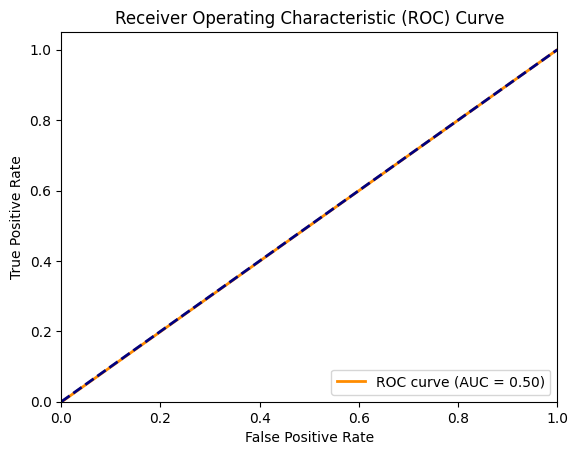

In [83]:
plt.figure()
plt.plot(fpr_3_5_turbo_main_part, tpr_3_5_turbo_main_part, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_3_5_turbo_main_part)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

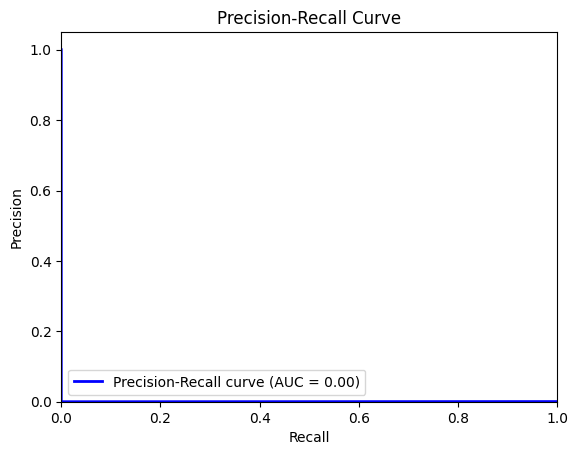

In [84]:
plt.figure()
plt.plot(pr_auc_recall_3_5_turbo_main_part, pr_auc_precision_3_5_turbo_main_part, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_3_5_turbo_main_part)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

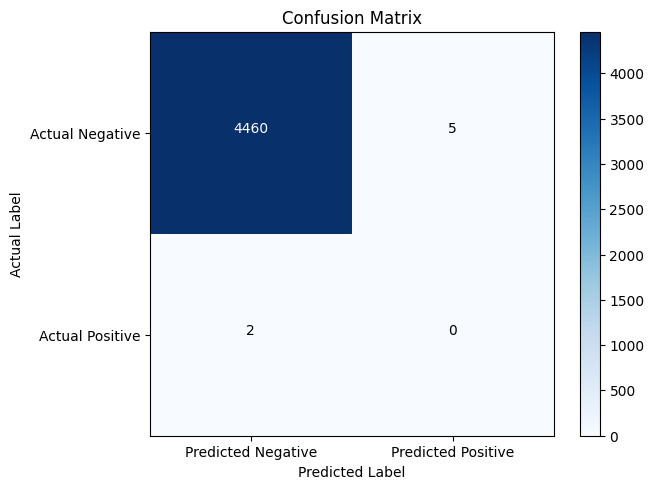

In [85]:
plt.figure()
plt.imshow(conf_matrix_3_5_turbo_main_part, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

thresh = conf_matrix_3_5_turbo_main_part.max() / 2.
for i in range(conf_matrix_3_5_turbo_main_part.shape[0]):
    for j in range(conf_matrix_3_5_turbo_main_part.shape[1]):
        plt.text(j, i, format(conf_matrix_3_5_turbo_main_part[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_3_5_turbo_main_part[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

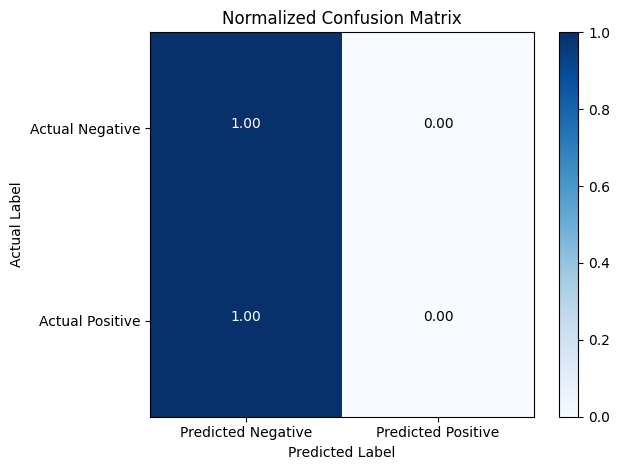

In [86]:
plt.figure()
plt.imshow(conf_matrix_norm_3_5_turbo_main_part, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
thresh = conf_matrix_norm_3_5_turbo_main_part.max() / 2.
for i in range(conf_matrix_norm_3_5_turbo_main_part.shape[0]):
    for j in range(conf_matrix_norm_3_5_turbo_main_part.shape[1]):
        plt.text(j, i, format(conf_matrix_norm_3_5_turbo_main_part[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix_norm_3_5_turbo_main_part[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()


#### For Benefit Redundancy

In [87]:
ground_truth_3_5_turbo_benefit: np.array
predicted_redundancy_3_5_turbo_benefit: np.array
tp_3_5_turbo_benefit: int = 0
fp_3_5_turbo_benefit: int = 0
tn_3_5_turbo_benefit: int = 0
fn_3_5_turbo_benefit: int = 0

In [88]:
ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit, tp_3_5_turbo_benefit, fp_3_5_turbo_benefit, tn_3_5_turbo_benefit, fn_3_5_turbo_benefit = calc_benefit_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-3.5-turbo'])

In [89]:

assert len(ground_truth_3_5_turbo_benefit) == len(predicted_redundancy_3_5_turbo_benefit)
print("Ground Truth:", ground_truth_3_5_turbo_benefit)
print("Predicted:", predicted_redundancy_3_5_turbo_benefit)
print("True Positives (TP):", tp_3_5_turbo_benefit)
print("False Positives (FP):", fp_3_5_turbo_benefit)
print("True Negatives (TN):", tn_3_5_turbo_benefit)
print("False Negatives (FN):", fn_3_5_turbo_benefit)

Ground Truth: [0 0 0 ... 0 0 0]
Predicted: [0 0 0 ... 0 0 0]
True Positives (TP): 2
False Positives (FP): 2
True Negatives (TN): 4459
False Negatives (FN): 4


In [90]:
precision_3_5_turbo_benefit = sklearn.metrics.precision_score(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
recall_3_5_turbo_benefit = recall_score(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
f1_3_5_turbo_benefit = f1_score(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit, average='binary')
accuracy_3_5_turbo_benefit = accuracy_score(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)

sensitivity_3_5_turbo_benefit = tp_3_5_turbo_benefit / (tp_3_5_turbo_benefit + fn_3_5_turbo_benefit + EPSILON) 
specificity_3_5_turbo_benefit = tn_3_5_turbo_benefit / (tn_3_5_turbo_benefit + fp_3_5_turbo_benefit + EPSILON)
fpr_manual_3_5_turbo_benefit = fp_3_5_turbo_benefit / (fp_3_5_turbo_benefit + tn_3_5_turbo_benefit + EPSILON)

#Confusion Matrix
conf_matrix_3_5_turbo_benefit = confusion_matrix(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
conf_matrix_norm_3_5_turbo_benefit = conf_matrix_3_5_turbo_benefit.astype('float') / conf_matrix_3_5_turbo_benefit.sum(axis=1)[:, np.newaxis]

#This is needed for plotting
fpr_3_5_turbo_benefit, tpr_3_5_turbo_benefit, thresholds_3_5_turbo_benefit = roc_curve(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
roc_auc_3_5_turbo_benefit = auc(fpr_3_5_turbo_main_part, tpr_3_5_turbo_main_part)

# Precision-Recall Curve and AUC-PR
pr_auc_precision_3_5_turbo_benefit, pr_auc_recall_3_5_turbo_benefit, __3_5_turbo_benefit = precision_recall_curve(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
pr_auc_3_5_turbo_benefit = auc(pr_auc_recall_3_5_turbo_benefit, pr_auc_precision_3_5_turbo_benefit)

In [91]:
print("Precision:", precision_3_5_turbo_benefit)
print("Recall:",recall_3_5_turbo_benefit)
print("F1:",f1_3_5_turbo_benefit)
print("Accuracy:",accuracy_3_5_turbo_benefit)
print("Sensitivity:",sensitivity_3_5_turbo_benefit)
print("Specificity:",specificity_3_5_turbo_benefit)
print("False positive rate:", fpr_manual_3_5_turbo_benefit)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_3_5_turbo_benefit)
print("Normalised Confusion Matrix:", conf_matrix_norm_3_5_turbo_benefit)
print("-" * 5)
print("AUC-ROC:", roc_auc_3_5_turbo_benefit)
print("AUC-PR:", pr_auc_3_5_turbo_benefit)

Precision: 0.5
Recall: 0.3333333333333333
F1: 0.4
Accuracy: 0.9986568166554735
Sensitivity: 0.3333333333333333
Specificity: 0.9995516700291415
False positive rate: 0.0004483299708585519
-----
Confusion Matrix: [[4459    2]
 [   4    2]]
Normalised Confusion Matrix: [[9.99551670e-01 4.48329971e-04]
 [6.66666667e-01 3.33333333e-01]]
-----
AUC-ROC: 0.49944008958566627
AUC-PR: 0.41711439444817555


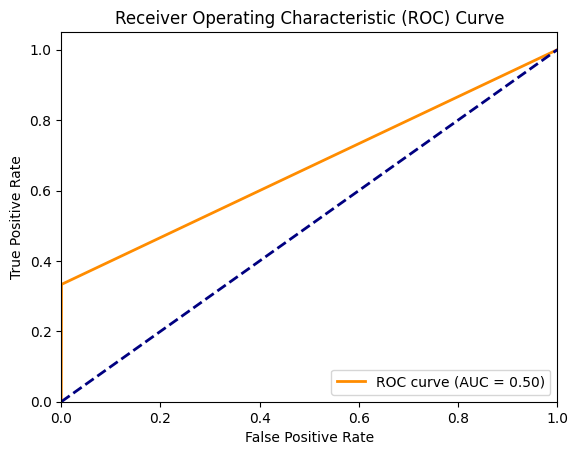

In [92]:
plt.figure()
plt.plot(fpr_3_5_turbo_benefit, tpr_3_5_turbo_benefit, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_3_5_turbo_benefit)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

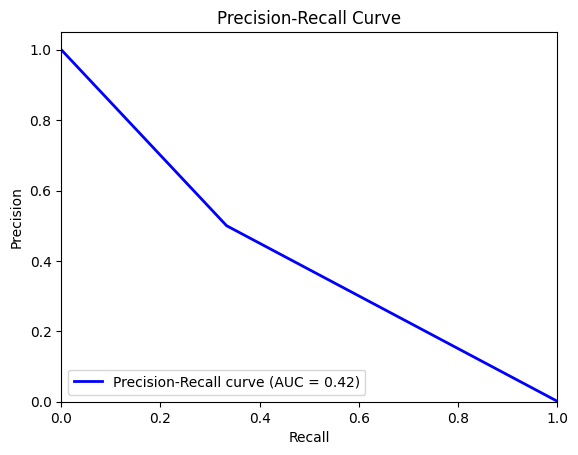

In [93]:
plt.figure()
plt.plot(pr_auc_recall_3_5_turbo_benefit, pr_auc_precision_3_5_turbo_benefit, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_3_5_turbo_benefit)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

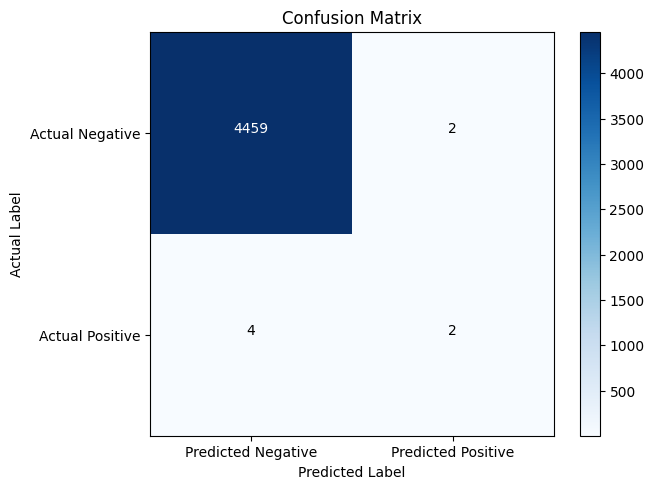

In [94]:
plt.figure()
plt.imshow(conf_matrix_3_5_turbo_benefit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

thresh = conf_matrix_3_5_turbo_benefit.max() / 2.
for i in range(conf_matrix_3_5_turbo_benefit.shape[0]):
    for j in range(conf_matrix_3_5_turbo_benefit.shape[1]):
        plt.text(j, i, format(conf_matrix_3_5_turbo_benefit[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_3_5_turbo_benefit[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

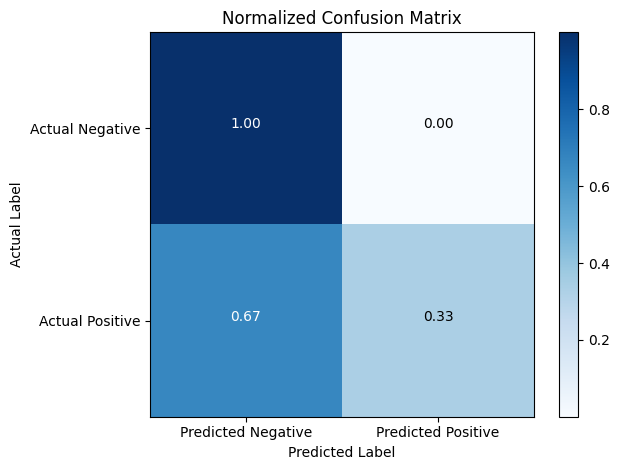

In [95]:
plt.figure()
plt.imshow(conf_matrix_norm_3_5_turbo_benefit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
thresh = conf_matrix_norm_3_5_turbo_benefit.max() / 2.
for i in range(conf_matrix_norm_3_5_turbo_benefit.shape[0]):
    for j in range(conf_matrix_norm_3_5_turbo_benefit.shape[1]):
        plt.text(j, i, format(conf_matrix_norm_3_5_turbo_benefit[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix_norm_3_5_turbo_benefit[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()

#### redundancy-model-gpt-4o

#### Time Consumption

In [96]:
total_time_per_file_4, avg_time_per_file_4, total_time_4, avg_time_4 = calc_time_consumption(chat_gpt_results['redundancy-model-gpt-4-turbo'])

#### For Main Part Redundancy (Full/Partial?)

In [97]:
###Both was flatten based on the predicted dataset
ground_truth_4o_main_part: np.array
predicted_redundancy_4o_main_part: np.array
tp_4o_main_part: int = 0
fp_4o_main_part: int = 0
tn_4o_main_part: int = 0
fn_4o_main_part: int = 0

In [98]:
ground_truth_4o_main_part, predicted_redundancy_4o_main_part, tp_4o_main_part, fp_4o_main_part, tn_4o_main_part, fn_4o_main_part = calc_main_part_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-4-turbo'])

In [99]:
assert len(ground_truth_4o_main_part) == len(predicted_redundancy_4o_main_part)
print("Ground Truth:", ground_truth_4o_main_part)
print("Predicted:", predicted_redundancy_4o_main_part)
print("True Positives (TP):" ,tp_4o_main_part)
print("False Positives (FP):", fp_4o_main_part)
print("True Negatives (TN):", tn_4o_main_part)
print("False Negatives (FN):", fn_4o_main_part)

Ground Truth: [0]
Predicted: [1]
True Positives (TP): 0
False Positives (FP): 1
True Negatives (TN): 0
False Negatives (FN): 0


In [100]:
precision_4o_main_part = precision_score(ground_truth_4o_main_part, predicted_redundancy_4o_main_part, average='binary')
recall_4o_main_part = recall_score(ground_truth_4o_main_part, predicted_redundancy_4o_main_part, average='binary')
f1_4o_main_part = f1_score(ground_truth_4o_main_part, predicted_redundancy_4o_main_part, average='binary')
accuracy_4o_main_part = accuracy_score(ground_truth_4o_main_part, predicted_redundancy_4o_main_part)

sensitivity_4o_main_part = tp_4o_main_part / (tp_4o_main_part + fn_4o_main_part + EPSILON) 
specificity_4o_main_part = tn_4o_main_part / (tn_4o_main_part + fp_4o_main_part + EPSILON)
fpr_manual_4o_main_part = fp_4o_main_part / (fp_4o_main_part + tn_4o_main_part + EPSILON)

#Confusion Matrix
conf_matrix_4o_main_part = confusion_matrix(ground_truth_4o_main_part, predicted_redundancy_4o_main_part)
conf_matrix_norm_4o_main_part = conf_matrix_4o_main_part.astype('float') / conf_matrix_4o_main_part.sum(axis=1)[:, np.newaxis]

#This is needed for plotting
fpr_4o_main_part, tpr_4o_main_part, thresholds_4o_main_part = roc_curve(ground_truth_4o_main_part, predicted_redundancy_4o_main_part)
roc_auc_4o_main_part = auc(fpr_4o_main_part, tpr_4o_main_part)

# Precision-Recall Curve and AUC-PR
pr_auc_precision_4o_main_part, pr_auc_recall_4o_main_part, __4o_main_part = precision_recall_curve(ground_truth_4o_main_part, predicted_redundancy_4o_main_part)
pr_auc_4o_main_part = auc(pr_auc_recall_4o_main_part, pr_auc_precision_4o_main_part)


d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lukas Hofmann\AppData\Local\Temp\ipykernel_16784\3991776517.py:12: RuntimeWarning: invalid value encountered in divide
  conf_matrix_norm_4o_main_part = conf_matrix_4o_main_part.astype('float') / conf_matrix_4o_main_part.sum(axis=1)[:, np.newaxis]
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to

In [101]:
print("Precision:", precision_4o_main_part)
print("Recall:",recall_4o_main_part)
print("F1:",f1_4o_main_part)
print("Accuracy:",accuracy_4o_main_part)
print("Sensitivity:",sensitivity_4o_main_part)
print("Specificity:",specificity_4o_main_part)
print("False positive rate:", fpr_manual_4o_main_part)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_4o_main_part)
print("Normalised Confusion Matrix:", conf_matrix_norm_4o_main_part)
print("-" * 5)
print("AUC-ROC:", roc_auc_4o_main_part)
print("AUC-PR:", pr_auc_4o_main_part)

Precision: 0.0
Recall: 0.0
F1: 0.0
Accuracy: 0.0
Sensitivity: 0.0
Specificity: 0.0
False positive rate: 1.0
-----
Confusion Matrix: [[0 1]
 [0 0]]
Normalised Confusion Matrix: [[ 0.  1.]
 [nan nan]]
-----
AUC-ROC: nan
AUC-PR: 0.5


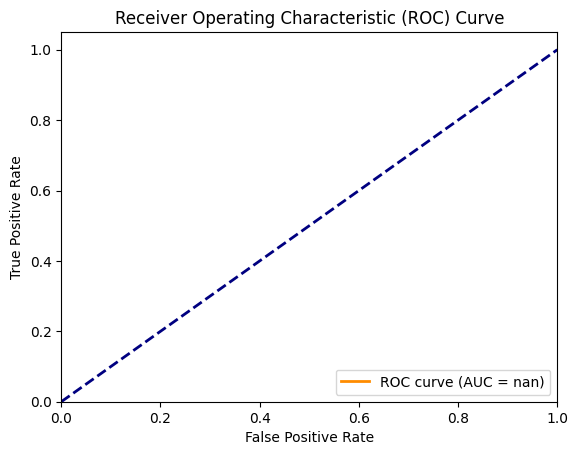

In [102]:
plt.figure()
plt.plot(fpr_4o_main_part, tpr_4o_main_part, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_4o_main_part)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

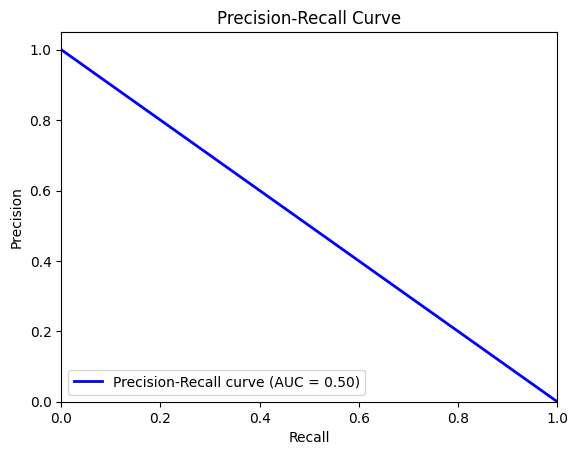

In [103]:
plt.figure()
plt.plot(pr_auc_recall_4o_main_part, pr_auc_precision_4o_main_part, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_4o_main_part)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

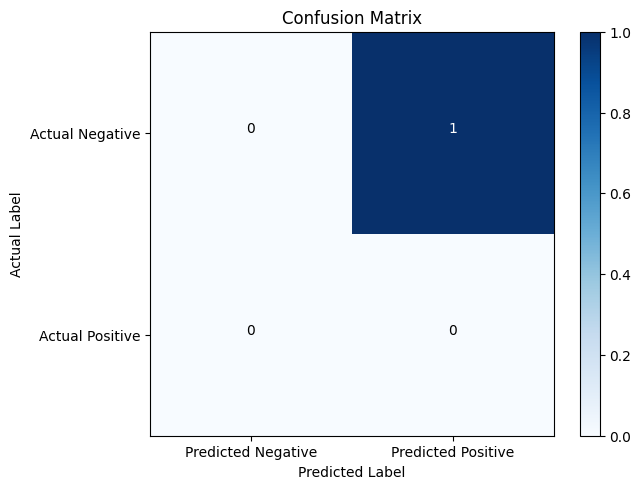

In [104]:
plt.figure()
plt.imshow(conf_matrix_4o_main_part, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

thresh = conf_matrix_4o_main_part.max() / 2.
for i in range(conf_matrix_4o_main_part.shape[0]):
    for j in range(conf_matrix_4o_main_part.shape[1]):
        plt.text(j, i, format(conf_matrix_4o_main_part[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_4o_main_part[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

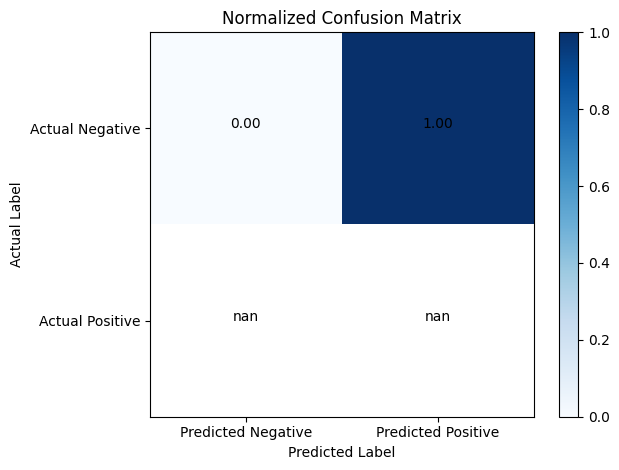

In [105]:
plt.figure()
plt.imshow(conf_matrix_norm_4o_main_part, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
thresh = conf_matrix_norm_4o_main_part.max() / 2.
for i in range(conf_matrix_norm_4o_main_part.shape[0]):
    for j in range(conf_matrix_norm_4o_main_part.shape[1]):
        plt.text(j, i, format(conf_matrix_norm_4o_main_part[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix_norm_4o_main_part[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()


#### For Benefit Redundancy

In [106]:
ground_truth_4o_benefit: np.array
predicted_redundancy_4o_benefit: np.array
tp_4o_benefit: int = 0
fp_4o_benefit: int = 0
tn_4o_benefit: int = 0
fn_4o_benefit: int = 0

In [107]:
ground_truth_4o_benefit, predicted_redundancy_4o_benefit, tp_4o_benefit, fp_4o_benefit, tn_4o_benefit, fn_4o_benefit = calc_benefit_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-4-turbo'])

In [108]:
assert len(ground_truth_4o_benefit) == len(predicted_redundancy_4o_benefit)
print("Ground Truth:",ground_truth_4o_benefit)
print("Predicted:",predicted_redundancy_4o_benefit)
print("True Positives (TP):", tp_4o_benefit)
print("False Positives (FP):", fp_4o_benefit)
print("True Negatives (TN):", tn_4o_benefit)
print("False Negatives (FN):", fn_4o_benefit)

Ground Truth: [0]
Predicted: [1]
True Positives (TP): 0
False Positives (FP): 1
True Negatives (TN): 0
False Negatives (FN): 0


In [109]:
precision_4o_benefit = precision_score(ground_truth_4o_benefit, predicted_redundancy_4o_benefit, average='binary')
recall_4o_benefit = recall_score(ground_truth_4o_benefit, predicted_redundancy_4o_benefit, average='binary')
f1_4o_benefit = f1_score(ground_truth_4o_benefit, predicted_redundancy_4o_benefit, average='binary')
accuracy_4o_benefit = accuracy_score(ground_truth_4o_benefit, predicted_redundancy_4o_benefit)

sensitivity_4o_benefit = tp_4o_benefit / (tp_4o_benefit + fn_4o_benefit + EPSILON) 
specificity_4o_benefit = tn_4o_benefit / (tn_3_5_turbo_benefit + fp_4o_benefit + EPSILON)
fpr_manual_4o_benefit = fp_4o_benefit / (fp_4o_benefit + tn_4o_benefit + EPSILON)

#Confusion Matrix
conf_matrix_4o_benefit = confusion_matrix(ground_truth_4o_benefit, predicted_redundancy_4o_benefit)
conf_matrix_norm_4o_benefit = conf_matrix_4o_benefit.astype('float') / conf_matrix_4o_benefit.sum(axis=1)[:, np.newaxis]

#This is needed for plotting
fpr_4o_benefit, tpr_4o_benefit, thresholds_4o_benefit = roc_curve(ground_truth_4o_benefit, predicted_redundancy_4o_benefit)
roc_auc_4o_benefit = auc(fpr_4o_main_part, tpr_4o_main_part)

# Precision-Recall Curve and AUC-PR
pr_auc_precision_4o_benefit, pr_auc_recall_4o_benefit, __4o_benefit = precision_recall_curve(ground_truth_4o_benefit, predicted_redundancy_4o_benefit)
pr_auc_4o_benefit = auc(pr_auc_recall_4o_benefit, pr_auc_precision_4o_benefit)

d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lukas Hofmann\AppData\Local\Temp\ipykernel_16784\3734148322.py:12: RuntimeWarning: invalid value encountered in divide
  conf_matrix_norm_4o_benefit = conf_matrix_4o_benefit.astype('float') / conf_matrix_4o_benefit.sum(axis=1)[:, np.newaxis]
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one f

In [110]:
print("Precision:", precision_4o_benefit)
print("Recall:",recall_4o_benefit)
print("F1:",f1_3_5_turbo_benefit)
print("Accuracy:",accuracy_4o_benefit)
print("Sensitivity:",sensitivity_4o_benefit)
print("Specificity:",specificity_4o_benefit)
print("False positive rate:", fpr_manual_4o_benefit)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_4o_benefit)
print("Normalised Confusion Matrix:", conf_matrix_norm_4o_benefit)
print("-" * 5)
print("AUC-ROC:", roc_auc_4o_benefit)
print("AUC-PR:", pr_auc_4o_benefit)

Precision: 0.0
Recall: 0.0
F1: 0.4
Accuracy: 0.0
Sensitivity: 0.0
Specificity: 0.0
False positive rate: 1.0
-----
Confusion Matrix: [[0 1]
 [0 0]]
Normalised Confusion Matrix: [[ 0.  1.]
 [nan nan]]
-----
AUC-ROC: nan
AUC-PR: 0.5


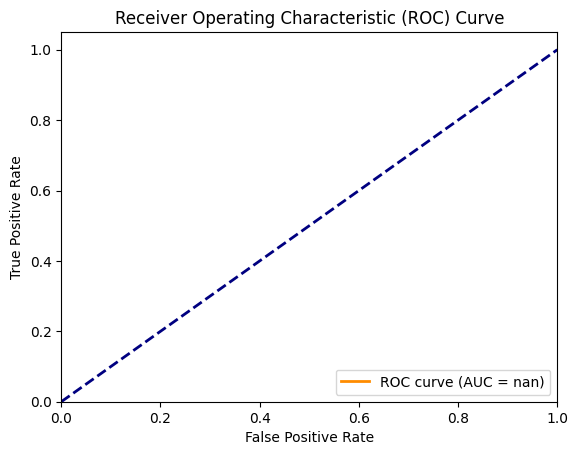

In [111]:
plt.figure()
plt.plot(fpr_4o_benefit, tpr_4o_benefit, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_4o_benefit)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

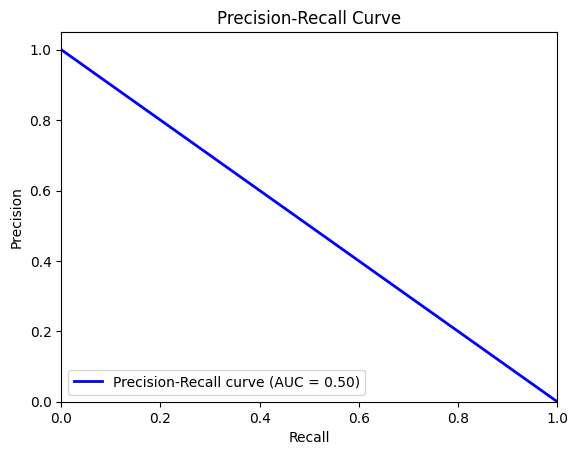

In [112]:
plt.figure()
plt.plot(pr_auc_recall_4o_benefit, pr_auc_precision_4o_benefit, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_4o_benefit)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

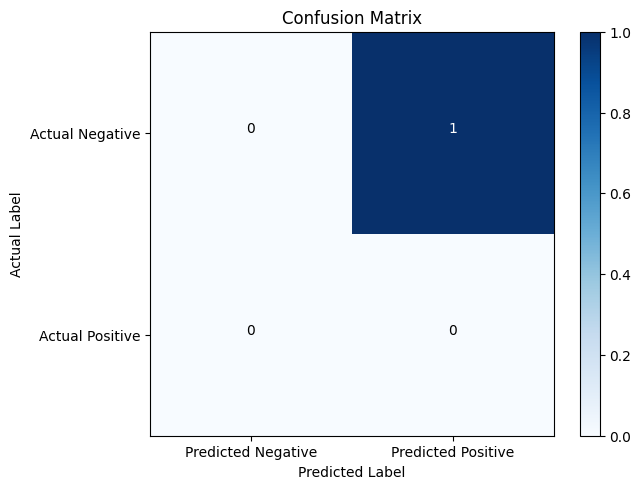

In [113]:
plt.figure()
plt.imshow(conf_matrix_4o_benefit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

thresh = conf_matrix_4o_benefit.max() / 2.
for i in range(conf_matrix_4o_benefit.shape[0]):
    for j in range(conf_matrix_4o_benefit.shape[1]):
        plt.text(j, i, format(conf_matrix_4o_benefit[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_4o_benefit[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

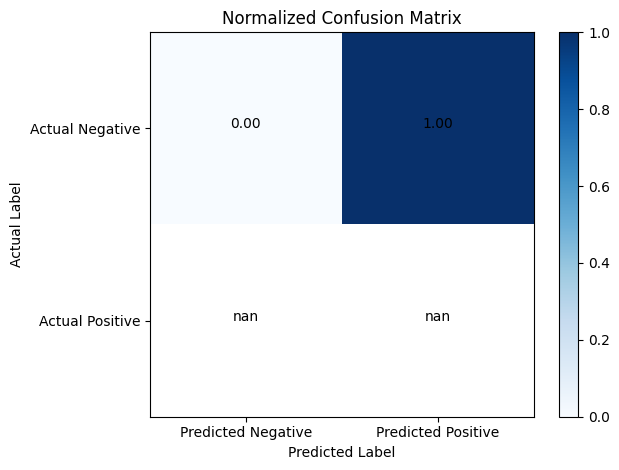

In [114]:
plt.figure()
plt.imshow(conf_matrix_norm_4o_benefit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
thresh = conf_matrix_norm_4o_benefit.max() / 2.
for i in range(conf_matrix_norm_4o_benefit.shape[0]):
    for j in range(conf_matrix_norm_4o_benefit.shape[1]):
        plt.text(j, i, format(conf_matrix_norm_4o_benefit[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix_norm_4o_benefit[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()

### Combinded ROC and PRC Curve

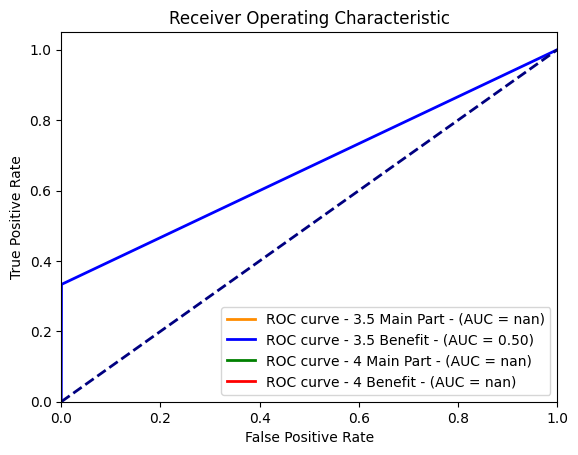

In [115]:
plt.figure()

plt.plot(fpr_4o_benefit, tpr_4o_benefit, color='darkorange', lw=2, label='ROC curve - 3.5 Main Part - (AUC = %0.2f)' % roc_auc_4o_benefit)
plt.plot(fpr_3_5_turbo_benefit, tpr_3_5_turbo_benefit, color='blue', lw=2, label='ROC curve - 3.5 Benefit - (AUC = %0.2f)' % roc_auc_3_5_turbo_benefit)
plt.plot(fpr_4o_main_part, tpr_4o_main_part, color='green', lw=2, label='ROC curve - 4 Main Part - (AUC = %0.2f)' % roc_auc_4o_main_part)
plt.plot(fpr_4o_benefit, tpr_4o_benefit, color='red', lw=2, label='ROC curve - 4 Benefit - (AUC = %0.2f)' % roc_auc_4o_benefit)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

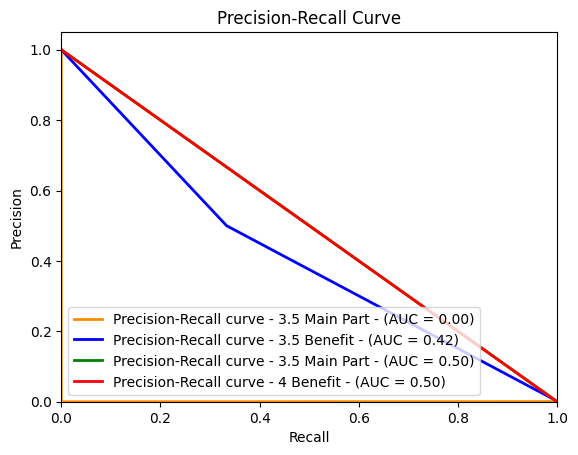

In [116]:
plt.figure()

plt.plot(pr_auc_recall_3_5_turbo_main_part, pr_auc_precision_3_5_turbo_main_part, color='darkorange', lw=2, label='Precision-Recall curve - 3.5 Main Part - (AUC = %0.2f)' % pr_auc_3_5_turbo_main_part)
plt.plot(pr_auc_recall_3_5_turbo_benefit, pr_auc_precision_3_5_turbo_benefit, color='blue', lw=2, label='Precision-Recall curve - 3.5 Benefit - (AUC = %0.2f)' % pr_auc_3_5_turbo_benefit)
plt.plot(pr_auc_recall_4o_main_part, pr_auc_precision_4o_main_part, color='green', lw=2, label='Precision-Recall curve - 3.5 Main Part - (AUC = %0.2f)' % pr_auc_4o_main_part)
plt.plot(pr_auc_recall_4o_benefit, pr_auc_precision_4o_benefit, color='red', lw=2, label='Precision-Recall curve - 4 Benefit - (AUC = %0.2f)' % pr_auc_4o_benefit)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Prepaire Dataframe with Resutls

In [117]:
def get_colomuns_metrics() -> list[str]: 
    return [
        'Model', 'Redundancy Part',
        'Ground Truth', 'Predicted', 'True Positives', 'False Positives', 
        'True Negatives', 'False Negatives', 'Precision', 'Recall', 
        'F1 Score', 'Accuracy', 'Sensitivity', 'Specificity', 'False Positive Rate'
    ]

def add_metrics_row(df: pd.DataFrame, model, redundancy_part, ground_truth, predicted, tp, fp, tn, fn, precision, recall, f1_score, accuracy, sensitivity, specificity, fpr):
    n_a2s = np.array2string
    new_row = pd.DataFrame({
        'Model': [model], 
        'Redundancy Part': [redundancy_part],
        'Ground Truth': [ground_truth], 
        'Predicted': [predicted], 
        'True Positives': [tp], 
        'False Positives': [fp], 
        'True Negatives': [tn], 
        'False Negatives': [fn], 
        'Precision': [precision], 
        'Recall': [recall],
        'F1 Score': [f1_score], 
        'Accuracy': [accuracy], 
        'Sensitivity': [sensitivity], 
        'Specificity': [specificity], 
        'False Positive Rate': [fpr]
    })
    return pd.concat([df, new_row], ignore_index=True)

def create_metrics_dataframe() -> pd.DataFrame:
    lv_metrics_df = pd.DataFrame(columns=get_colomuns_metrics())
    lv_metrics_df = add_metrics_row(lv_metrics_df, "ChatGPT 3.5 Turbo", "Main Part",
                                    ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part, tp_3_5_turbo_main_part, fp_3_5_turbo_main_part, tn_3_5_turbo_main_part, fn_3_5_turbo_main_part, precision_3_5_turbo_main_part, 
                                    recall_3_5_turbo_main_part, f1_3_5_turbo_main_part, accuracy_3_5_turbo_main_part, sensitivity_3_5_turbo_main_part, specificity_3_5_turbo_main_part, fpr_manual_3_5_turbo_main_part)
    
    lv_metrics_df = add_metrics_row(lv_metrics_df, "ChatGPT 3.5 Turbo", "Benefit",
                                    ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit, tp_3_5_turbo_benefit, fp_3_5_turbo_benefit, tn_3_5_turbo_benefit, fn_3_5_turbo_benefit, precision_3_5_turbo_benefit,
                                    recall_3_5_turbo_benefit, f1_3_5_turbo_benefit, accuracy_3_5_turbo_benefit, sensitivity_3_5_turbo_benefit, specificity_3_5_turbo_benefit, fpr_manual_3_5_turbo_benefit)
    
    lv_metrics_df = add_metrics_row(lv_metrics_df, "ChatGPT 4", "Main Part",
                                    ground_truth_4o_main_part, predicted_redundancy_4o_main_part, tp_4o_main_part, fp_4o_main_part, tn_4o_main_part, fn_4o_main_part, precision_4o_main_part,
                                    recall_4o_main_part, f1_4o_main_part, accuracy_4o_main_part, sensitivity_4o_main_part, specificity_4o_main_part, fpr_manual_4o_main_part)
    
    lv_metrics_df = add_metrics_row(lv_metrics_df, "ChatGPT 4o", "Benefit",
                                    ground_truth_4o_benefit, predicted_redundancy_4o_benefit, tp_4o_benefit, fp_4o_benefit, tn_4o_benefit, fn_4o_benefit, precision_4o_benefit,
                                    recall_4o_benefit, f1_4o_benefit, accuracy_4o_benefit, sensitivity_4o_benefit, specificity_4o_benefit, fpr_manual_4o_benefit)
    return lv_metrics_df

In [118]:
metrics_df: pd.DataFrame
metrics_df = create_metrics_dataframe() 
metrics_df.head()

C:\Users\Lukas Hofmann\AppData\Local\Temp\ipykernel_16784\431277350.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, new_row], ignore_index=True)


,Model,Redundancy Part,Ground Truth,Predicted,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score,Accuracy,Sensitivity,Specificity,False Positive Rate
0,ChatGPT 3.5 Turbo,Main Part,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,5,4460,2,0.0,0.000000,0.0,0.998433,0.000000,0.998880,0.001120
1,ChatGPT 3.5 Turbo,Benefit,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,2,4459,4,0.5,0.333333,0.4,0.998657,0.333333,0.999552,0.000448
2,ChatGPT 4,Main Part,[0],[1],0,1,0,0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
3,ChatGPT 4o,Benefit,[0],[1],0,1,0,0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000


## Analysing the Datasets for finding the false positives and false negatives and storing into an .xlsx file
This part can be used for further human analyses to determine for where the difference of the formal tool and ChatGPT chatbot is.

In [119]:
EXCEL_SPECIAL_CHAR_TO_REMOVE = ["_x000D_"]

def contains_special_characters(text: str) -> str:
    for special_char in EXCEL_SPECIAL_CHAR_TO_REMOVE:
        if special_char in text:
            text = text.replace(special_char, "")
    return text

def split_and_remove_prefix(snippet: pd.DataFrame) -> tuple[int, int]:
    PATTERN = r'^user_story_\d+: #\w+#'
    try:
        text: str = contains_special_characters(snippet.iloc[0]['User Stories Texts'])            
        formal_text_one, formal_text_two = text.split("\n\n")
    except Exception as e:
        print(snippet.iloc[0]['User Stories Texts'])
        raise e
    formal_text_one = re.sub(PATTERN, '', formal_text_one)
    formal_text_two = re.sub(PATTERN, '', formal_text_two)
    return formal_text_one, formal_text_two

def collecting_reasons_and_references(items: list) -> tuple[str, str, str]:
    reason_descriptions:str = ""
    reference_to_original_text_one:str  = ""
    reference_to_original_text_two:str = ""
    for idx, item in enumerate(items):
        reason_descriptions += f'{idx}.) {item['reasonDescription']}\n'
        reference_to_original_text_one += f'{idx}.) {item['referenceToOriginalText'][0]}\n\n'
        reference_to_original_text_two += f'{idx}.) {item['referenceToOriginalText'][1]}\n\n'
    return reason_descriptions, reference_to_original_text_one, reference_to_original_text_two

def raise_if_duplicated_usid_in_original_data(n: int, s1: str, s2: str):
    raise Exception(f'The User Story {n} appears at last twice. Once in {s1} and second in {s2}.')

def collect_original_text_pairs(ORIGINAL_DATASET: dict, usidone: int, usidtwo: int, original_text_one: str, original_text_two: str) -> tuple[str, str]:
    original_text_one_found_in: str = ''
    original_text_two_found_in: str = ''
    for key, values in ORIGINAL_DATASET.items():
        for value in values:
            if (value['id'] == usidone):
                if original_text_one:
                    raise_if_duplicated_usid_in_original_data(value['id'], original_text_one_found_in, key)
                original_text_one = value['text']
                original_text_one_found_in = key
            if (value['id'] == usidtwo):
                if original_text_two:
                    raise_if_duplicated_usid_in_original_data(value['id'], original_text_two_found_in, key)
                original_text_two = value['text']
                original_text_two_found_in = key
    if not original_text_one:
        original_text_one = "No text found in source"               
    if not original_text_two:
        original_text_two = "No text found in source"
    return original_text_one, original_text_two

def collect_project_id(ORIGINAL_DATASET: dict, usidone: int, usidtwo: int) -> str:
    i: int = 0
    for key, values in ORIGINAL_DATASET.items():
        for value in values:
            if (value['id'] == usidone):
                i += 1
            elif (value['id'] == usidtwo):
                i += 1
            elif (i == 2):
                return str(key).replace("#","")
    return None

### Getting false positives and false negatives

In [120]:
REDUNDANCY_CATEGORIES_FALSE_TYPE = ["False Positive", "False Negative"]
REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT = ["Main Part", "Benefit"]


DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES = {
    'Execution Run': 'int',
    'Model': 'str',
    'Dataset': 'str',
    'False Type': pd.CategoricalDtype(categories=REDUNDANCY_CATEGORIES_FALSE_TYPE),
    'Main Part or Benefit': pd.CategoricalDtype(categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
    'User Story Id 1': 'int',
    'User Story Id 2': 'int',
    'Reason from ChatGPT': 'str',
    'Refered Text 1 by ChatGPT': 'str',
    'Refered Text 1 from formal Approach or Original Text in case of false positive': 'str',
    'Refered Text 2 by ChatGPT': 'str',
    'Refered Text 2 from formal Approach or Original Text in case of false positive': 'str'
}
df_show_false_positives_negatives = pd.DataFrame(columns=DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES.keys()).astype(dtype=DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES)

In [121]:
def fill_df_show_false_positives_negatives(local_df_show_false_positives_negatives: pd.core.series.Series, model: str, chat_gpt_input_category: dict) -> pd.DataFrame:
    CATEGORY_FALSE_POSITIVE = "False Positive"
    CATEGORY_FALSE_NEGATIVE = "False Negative"
    CATEGORY_MAIN_PART = "Main Part"
    CATEGORY_BENEFIT = "Benefit"
    ORIGINAL_DATASET = load_datasets_add_line_counter()
    NO_REDUNDANCY_DETECTED_BY_LLM = "LLM did not return an answere as it did not detect a redundancy"
    
    def add_row_to_show_false_positives(local_df_show_false_positives_negatives: pd.DataFrame, execution_run: int, data_set:str, model: str, false_type: str, main_or_benefit: str, usid_one: int, 
                                    usid_two: int, reason_chat: str, text_chat_one: str, text_chat_two: str, text_formal_one: str, text_formal_two: str) -> pd.DataFrame:        
        new_row = pd.DataFrame({
            'Execution Run': [execution_run],
            'Dataset': [data_set],
            'Model': [model],
            'False Type': pd.Categorical([false_type], categories=REDUNDANCY_CATEGORIES_FALSE_TYPE),
            'Main Part or Benefit': pd.Categorical([main_or_benefit], categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
            'User Story Id 1': [usid_one],
            'User Story Id 2': [usid_two],
            'Reason from ChatGPT': [reason_chat],
            'Refered Text 1 by ChatGPT': [text_chat_one],
            'Refered Text 1 from formal Approach or Original Text in case of false positive': [text_formal_one],
            'Refered Text 2 by ChatGPT': [text_chat_two],
            'Refered Text 2 from formal Approach or Original Text in case of false positive': [text_formal_two]
        })
        return pd.concat([local_df_show_false_positives_negatives, new_row], ignore_index=True)
    
    original_text_one: str = ''
    original_text_two: str = ''
    usidone: int = 0
    usidtwo: int = 0
    run: int = 0
    
    for i, file in chat_gpt_input_category.items():
        file_content = file
        run = i.split("_")[0].strip()
        for item in file_content:
            # Collecting the informations from the .json-files
            reason_describtions_main_part, reference_to_original_text_one_main_part, reference_to_original_text_two_main_part = collecting_reasons_and_references(item['mainPartRedundancies'])
            reason_descriptions_benefit, reference_to_original_text_one_benefit, reference_to_original_text_two_benefit = collecting_reasons_and_references(item['benefitRedundancies'])
            usidone = 0
            usidtwo = 0
            try:
                usidone = int(item['relatedStories'][0])
                usidtwo = int(item['relatedStories'][1])
            except ValueError:
                raise Exception("Conversion failed: String did not contain a valid integer.")
            
            # Searching for the entry in the ground truth
            filtered_rows = excel_data[(excel_data['Corresponding USID 1'].astype(int) == usidone) 
                                        & (excel_data['Corresponding USID 2'].astype(int) == usidtwo)]
            dataset = collect_project_id(ORIGINAL_DATASET, usidone, usidtwo)
            if (filtered_rows.shape[0] == 1):
                # Collecting the informations from the ground truth
                formal_text_one, formal_text_two = split_and_remove_prefix(filtered_rows)
                
                if not bool(item['redundantMainPart']) or not bool(item['redundantBenefit']):
                    if not bool(item['redundantMainPart']) and bool(filtered_rows.iat[0, 6]):
                        local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                                dataset, model, CATEGORY_FALSE_NEGATIVE, 
                                                                                                CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                                NO_REDUNDANCY_DETECTED_BY_LLM,
                                                                                                NO_REDUNDANCY_DETECTED_BY_LLM, 
                                                                                                NO_REDUNDANCY_DETECTED_BY_LLM, 
                                                                                                formal_text_one,
                                                                                                formal_text_two)
                    if not bool(item['redundantBenefit']) and bool(filtered_rows.iat[0, 7]):
                        local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                                dataset, model, CATEGORY_FALSE_NEGATIVE, 
                                                                                                CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                                NO_REDUNDANCY_DETECTED_BY_LLM,
                                                                                                NO_REDUNDANCY_DETECTED_BY_LLM, 
                                                                                                NO_REDUNDANCY_DETECTED_BY_LLM, 
                                                                                                formal_text_one,
                                                                                                formal_text_two)
                if bool(item['redundantMainPart']) or bool(item['redundantBenefit']):
                    if bool(item['redundantMainPart']) and not bool(filtered_rows.iat[0, 6]):
                        local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                                dataset, model, CATEGORY_FALSE_POSITIVE, 
                                                                                                CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                                reason_describtions_main_part,
                                                                                                reference_to_original_text_one_main_part, 
                                                                                                reference_to_original_text_two_main_part, 
                                                                                                formal_text_one,
                                                                                                formal_text_two)
                    if bool(item['redundantBenefit']) and not bool(filtered_rows.iat[0, 7]):
                        local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                                dataset, model, CATEGORY_FALSE_POSITIVE, 
                                                                                                CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                                reason_describtions_main_part,
                                                                                                reference_to_original_text_one_main_part, 
                                                                                                reference_to_original_text_two_main_part, 
                                                                                                formal_text_one,
                                                                                                formal_text_two)
                # if ((not bool(item['redundantBenefit']) or not bool(filtered_rows.iat[0, 7]))
                #       and (bool(item['redundantBenefit']) or bool(filtered_rows.iat[0, 7]))):
                #     pass # true and false positives are not stored
                # else:
                #     raise UnboundLocalError("Not assignable: In Ground.")
            elif (filtered_rows.shape[0] >= 2):
                raise Exception("There are more than or equal to 2 filtered rows.\n" + f"JSON File: {item}\n" + f"Excel{filtered_rows}")
            else:
                # Searching for the original text in the original data
                original_text_one = ''
                original_text_two = ''
                original_text_one, original_text_two = collect_original_text_pairs(ORIGINAL_DATASET, usidone, usidtwo, original_text_one, original_text_two)
                
                #Searching for the false positives. Thus, the reveresed case is also check.
                if bool(item['redundantMainPart']) or bool(item['redundantBenefit']):
                    if bool(item['redundantMainPart']):
                        local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                                dataset, model, CATEGORY_FALSE_POSITIVE, 
                                                                                                CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                                reason_describtions_main_part,
                                                                                                reference_to_original_text_one_main_part, 
                                                                                                reference_to_original_text_two_main_part, 
                                                                                                original_text_two,
                                                                                                original_text_two)                
                    if bool(item['redundantBenefit']):
                            local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                                    dataset, model, CATEGORY_FALSE_POSITIVE, 
                                                                                                    CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                                    reason_descriptions_benefit,
                                                                                                    reference_to_original_text_one_benefit, 
                                                                                                    reference_to_original_text_two_benefit, 
                                                                                                    original_text_two,
                                                                                                    original_text_two)
                elif not bool(item['redundantMainPart']) and not bool(item['redundantBenefit']):
                    pass # true negatives are not stored
                else:
                    raise UnboundLocalError("Not assignable: Not in Ground.")
    return local_df_show_false_positives_negatives

In [122]:
df_show_false_positives_negatives = df_show_false_positives_negatives.drop(df_show_false_positives_negatives.index)
for key in chat_gpt_result_keys: 
    show_false_positives = chat_gpt_results[key]
    match = re.search(r'gpt.*$', key)
    df_show_false_positives_negatives = fill_df_show_false_positives_negatives(df_show_false_positives_negatives, match.group(), show_false_positives)
df_show_false_positives_negatives.head(5)

,Execution Run,Model,Dataset,False Type,Main Part or Benefit,User Story Id 1,User Story Id 2,Reason from ChatGPT,Refered Text 1 by ChatGPT,Refered Text 1 from formal Approach or Original Text in case of false positive,Refered Text 2 by ChatGPT,Refered Text 2 from formal Approach or Original Text in case of false positive
0,00,gpt-3.5-turbo,G03,False Positive,Main Part,326,353,0.) The redundancy arises from the repetition ...,"0.) As a Staff member, I want to Assign an App...","as a staff member, i want to assign an applic...","0.) As a Plan Review Staff member, I want to R...","as a plan review staff member, i want to revi..."
1,00,gpt-3.5-turbo,G03,False Negative,Benefit,331,344,LLM did not return an answere as it did not de...,LLM did not return an answere as it did not de...,"as a staff member, i want to manage approved ...",LLM did not return an answere as it did not de...,"as a staff member, i want to manage affidavit..."
2,00,gpt-3.5-turbo,G03,False Positive,Benefit,345,346,0.) The redundancy in benefits lies in the rep...,0.) I can ensure all pre-hearing requirements ...,"As a Staff member, I want to Prepare for and S...",0.) I can ensure all pre-hearing requirements ...,"As a Staff member, I want to Prepare for and S..."
3,00,gpt-3.5-turbo,G04,False Negative,Benefit,168,175,LLM did not return an answere as it did not de...,LLM did not return an answere as it did not de...,"as a user, i want to have a flexible pick up ...",LLM did not return an answere as it did not de...,"as a user, i want to choose a flexible pick u..."
4,00,gpt-3.5-turbo,G04,False Positive,Main Part,168,175,0.) The redundancy arises from the repetition ...,"0.) As a user, I want to have a flexible pick ...","as a user, i want to have a flexible pick up ...","0.) As a user, I want to choose a flexible pic...","as a user, i want to choose a flexible pick u..."


### Getting the true positives

In [123]:
DF_SHOW_TRUE_POSITIVES_DTYPES = {
    'Execution Run': 'int',
    'Dataset': 'str',
    'Model': 'str',
    'Main Part or Benefit': pd.CategoricalDtype(categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
    'User Story Id 1': 'int',
    'User Story Id 2': 'int',
    'Reason from ChatGPT': 'str',
    'Refered Text 1 by ChatGPT': 'str',
    'Refered Text 1 from formal Approach': 'str',
    'Refered Text 2 by ChatGPT': 'str',
    'Refered Text 2 from formal Approach': 'str'
}
df_show_true_positives = pd.DataFrame(columns=DF_SHOW_TRUE_POSITIVES_DTYPES.keys()).astype(dtype=DF_SHOW_TRUE_POSITIVES_DTYPES)

In [124]:
def fill_df_show_true_positives(local_df_show_true_positives: pd.core.series.Series, model: str, chat_gpt_input_category: dict) -> pd.DataFrame:
    CATEGORY_MAIN_PART = "Main Part"
    CATEGORY_BENEFIT = "Benefit"
    
    def add_row_to_show_true_positives(local_df_show_true_positives: pd.DataFrame, execution_run: int, dataset:str, model: str, main_or_benefit: str, usid_one: int, 
                                    usid_two: int, reason_chat: str, text_chat_one: str, text_chat_two: str, text_formal_one: str, text_formal_two: str) -> pd.DataFrame:
        new_row = pd.DataFrame({
            'Execution Run':[execution_run],
            'Dataset': [dataset],
            'Model': [model],
            'Main Part or Benefit': pd.Categorical([main_or_benefit], categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
            'User Story Id 1': [usid_one],
            'User Story Id 2': [usid_two],
            'Reason from ChatGPT': [reason_chat],
            'Refered Text 1 by ChatGPT': [text_chat_one],
            'Refered Text 1 from formal Approach': [text_formal_one],
            'Refered Text 2 by ChatGPT': [text_chat_two],
            'Refered Text 2 from formal Approach': [text_formal_two]
        })
        return pd.concat([local_df_show_true_positives, new_row], ignore_index=True)
    
    usidone: int = 0
    usidtwo: int = 0
    run: int = None
    project_id_name: str = None
    for i, file in chat_gpt_input_category.items():
        file_content = file
        run = i.split("_")[0].strip()
        for item in file_content:
            filtered_rows = excel_data[(excel_data['Corresponding USID 1'].astype(int) == int(item['relatedStories'][0])) 
                                        & (excel_data['Corresponding USID 2'].astype(int) == int(item['relatedStories'][1]))]

            if (filtered_rows.shape[0] == 1):
                formal_text_one, formal_text_two = split_and_remove_prefix(filtered_rows)
                reason_describtions_main_part, reference_to_original_text_one_main_part, reference_to_original_text_two_main_part = collecting_reasons_and_references(item['benefitRedundancies'])
                reason_describtions_benefit, reference_to_original_text_one_benefit, reference_to_original_text_two_benefit = collecting_reasons_and_references(item['benefitRedundancies'])

                try:
                    usidone = int(item['relatedStories'][0])
                    usidtwo = int(item['relatedStories'][1])
                except ValueError:
                    raise Exception("Conversion failed: String did not contain a valid integer.")

                ### ---> Check if filtered_row is correct or the excel should be taken
                #Searching for the true positives for main part and benefit.
                project_id_name = filtered_rows.iat[0,0]
                if bool(item['redundantMainPart']) and bool(filtered_rows.iat[0, 6]):
                    local_df_show_true_positives = add_row_to_show_true_positives(local_df_show_true_positives, run, project_id_name,
                                                                                               model, CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                               reason_describtions_main_part,
                                                                                               reference_to_original_text_one_main_part, 
                                                                                               reference_to_original_text_two_main_part, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
                    
                if bool(item['redundantBenefit']) and bool(filtered_rows.iat[0, 7]):
                    local_df_show_true_positives = add_row_to_show_true_positives(local_df_show_true_positives, run, project_id_name,
                                                                                               model, CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                               reason_describtions_benefit,
                                                                                               reference_to_original_text_one_benefit, 
                                                                                               reference_to_original_text_two_benefit, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
            elif (filtered_rows.shape[0] >= 2):
                raise Exception(f"There are more than or equal to 2 filtered rows.\n JSON File: {item}\n Excel{filtered_rows}")
    return local_df_show_true_positives

In [125]:
df_show_true_positives = df_show_true_positives.drop(df_show_true_positives.index)
for key in chat_gpt_result_keys: 
    show_true_positives: dict = chat_gpt_results[key]
    match = re.search(r'gpt.*$', key)
    df_show_true_positives = fill_df_show_true_positives(df_show_true_positives, match.group(), show_true_positives)
df_show_true_positives.head(5)

,Execution Run,Dataset,Model,Main Part or Benefit,User Story Id 1,User Story Id 2,Reason from ChatGPT,Refered Text 1 by ChatGPT,Refered Text 1 from formal Approach,Refered Text 2 by ChatGPT,Refered Text 2 from formal Approach
0,00,G03,gpt-3.5-turbo,Benefit,326,353,0.) The redundancy in these sentences lies in ...,0.) so that I can review the for compliance an...,"as a staff member, i want to assign an applic...",0.) so that I can review them for compliance a...,"as a plan review staff member, i want to revi..."
1,01,G03,gpt-3.5-turbo,Benefit,326,353,0.) The redundancy in these sentences lies in ...,0.) so that I can review the for compliance an...,"as a staff member, i want to assign an applic...",0.) so that I can review them for compliance a...,"as a plan review staff member, i want to revi..."


### Saving the data results

In [126]:
## Formatter metric
def formatter_metric(wb: Workbook, sheet_name: str): 
    ws: Worksheet = wb[sheet_name]
    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
    
    ADDITIONAL_LENGTH: int = 0
    ADJUSTED_WIDTH: int = 0
    MAX_LEN: int = 0
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            MAX_LEN = len(str(cell.value))
            ADDITIONAL_LENGTH = (MAX_LEN + 2)
            ADJUSTED_WIDTH = 0
            if cell.col_idx == 1 or cell.col_idx == 2 or cell.col_idx == 3 or cell.col_idx == 12:
                ADJUSTED_WIDTH =  ADDITIONAL_LENGTH * 1.5
            else:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.2
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = ADJUSTED_WIDTH
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = wrap_alignment
    
    yellow_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")
    for row in ws.iter_rows(min_row=1):
        if len(row) >= 3:
            row[5].fill = yellow_fill
        if len(row) >= 5:
            row[7].fill = yellow_fill

In [127]:
save_to_excel(metrics_df, formatter_metric, 'Only US-Result')

In [128]:
## Formatter False Positives, False Negatives
def formatter_fpn(wb: Workbook, sheet_name: str): 
    ws: Worksheet = wb[sheet_name]
    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
    
    ADDITIONAL_LENGTH: int = 0
    ADJUSTED_WIDTH: int = 0
    MAX_LEN: int = 0
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            MAX_LEN = len(str(cell.value))
            ADDITIONAL_LENGTH = (MAX_LEN + 2)
            ADJUSTED_WIDTH = 0
            if cell.col_idx == 2:
                ADJUSTED_WIDTH =  ADDITIONAL_LENGTH * 1.5
            elif cell.col_idx == 1 or cell.col_idx == 7 or cell.col_idx == 8:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.3
            elif cell.col_idx == 9 or cell.col_idx == 11:
                ADJUSTED_WIDTH = (ADDITIONAL_LENGTH * 1.2) / 2
            else:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.2
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = ADJUSTED_WIDTH
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=1):
        for cell in row:
            cell.alignment = wrap_alignment

In [129]:
save_to_excel(df_show_false_positives_negatives, formatter_fpn, 'Only US-False Pos. Neg.')

In [130]:
## Formatter true positives
def formatter_tp(wb: Workbook, sheet_name: str): 
    ws: Worksheet = wb[sheet_name]
    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
    
    ADDITIONAL_LENGTH: int = 0
    ADJUSTED_WIDTH: int = 0
    MAX_LEN: int = 0
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            MAX_LEN = len(str(cell.value))
            ADDITIONAL_LENGTH = (MAX_LEN + 2)
            ADJUSTED_WIDTH = 0
            if cell.col_idx == 2:
                ADJUSTED_WIDTH =  ADDITIONAL_LENGTH * 1.5
            elif cell.col_idx == 1 or cell.col_idx == 6 or cell.col_idx == 7 or cell.col_idx == 8:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.3
            else:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.2
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = ADJUSTED_WIDTH
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = wrap_alignment

In [131]:
save_to_excel(df_show_true_positives, formatter_tp, 'Only US-True Pos.')

In [132]:
time_consumption_data: pd.DataFrame = None

if (set(total_time_per_file_3_5['key']) == set(avg_time_per_file_3_5['key']) and set(total_time_per_file_4['key']) == set(avg_time_per_file_4['key'])):
    ns_ms_ratio: int = 1_000_000
    ns_sec_ratio: int = 1_000_000_000
    ns_min_ratio: int = 60_000_000_000
    time_consumption_data = pd.DataFrame({
        'Version': ["v3.5", "v4"],
        'Groups': ["All sets", "All sets"],
        'Total Time (ns)': [total_time_3_5, total_time_4],
        'Avg Time (ns)': [avg_time_3_5, avg_time_4],
        'Total Time (ms)': [total_time_3_5 / ns_ms_ratio, total_time_4 / ns_ms_ratio],
        'Avg Time (ms)': [avg_time_3_5 / ns_ms_ratio, avg_time_4 / ns_ms_ratio],
        'Total Time (s)': [total_time_3_5 / ns_sec_ratio, total_time_4 / ns_sec_ratio],
        'Avg Time (s)': [avg_time_3_5 / ns_sec_ratio, avg_time_4 / ns_sec_ratio],
        'Total Time (m)': [total_time_3_5 / ns_min_ratio, total_time_4 / ns_min_ratio],
        'Avg Time (m)': [avg_time_3_5 / ns_min_ratio, avg_time_4 / ns_min_ratio]
    })


    keys_collection_3_5 = total_time_per_file_3_5['key']
    times_collection_3_5 = total_time_per_file_3_5['time']
    avg_times_collection_3_5 = avg_time_per_file_3_5['avg_time']
    df_times_3_5: pd.DataFrame = pd.DataFrame({
        'Version': "v3.5",
        'Groups': keys_collection_3_5,
        'Total Time (ns)': times_collection_3_5,
        'Avg Time (ns)': avg_times_collection_3_5,
        'Total Time (ms)': times_collection_3_5 / ns_ms_ratio,
        'Avg Time (ms)': avg_times_collection_3_5 / ns_ms_ratio,
        'Total Time (s)': times_collection_3_5 / ns_sec_ratio,
        'Avg Time (s)': avg_times_collection_3_5 / ns_sec_ratio,
        'Total Time (m)': times_collection_3_5 / ns_min_ratio,
        'Avg Time (m)': avg_times_collection_3_5 / ns_min_ratio
    })

    keys_collection_4 = total_time_per_file_4['key']
    times_collection_4 = total_time_per_file_4['time']
    avg_times_collection_4 = avg_time_per_file_4['avg_time']
    df_times_4: pd.DataFrame = pd.DataFrame({
        'Version': "v4",
        'Groups': keys_collection_4,
        'Total Time (ns)': times_collection_4,
        'Avg Time (ns)': avg_times_collection_4,
        'Total Time (ms)': times_collection_4 / ns_ms_ratio,
        'Avg Time (ms)': avg_times_collection_4 / ns_ms_ratio,
        'Total Time (s)': times_collection_4 / ns_sec_ratio,
        'Avg Time (s)': avg_times_collection_4 / ns_sec_ratio,
        'Total Time (m)': times_collection_4 / ns_min_ratio,
        'Avg Time (m)': avg_times_collection_4  / ns_min_ratio
    })

    local_time_consumption_data: pd.DataFrame = pd.concat([df_times_3_5, df_times_4], ignore_index=True)
    time_consumption_data = pd.concat([time_consumption_data, local_time_consumption_data])
else:
    raise RuntimeError("Not the same keys in the ndarray")

time_consumption_data.head()

,Version,Groups,Total Time (ns),Avg Time (ns),Total Time (ms),Avg Time (ms),Total Time (s),Avg Time (s),Total Time (m),Avg Time (m)
0,v3.5,All sets,6.787224e+12,1.519414e+09,6.787224e+06,1519.414377,6787.224024,1.519414,1.131204e+02,2.532357e-02
1,v4,All sets,1.000000e+03,1.000000e+03,1.000000e-03,0.001000,0.000001,0.000001,1.666667e-08,1.666667e-08
0,v3.5,00_#G03#,2.450748e+12,1.535556e+09,2.450748e+06,1535.556380,2450.747983,1.535556,4.084580e+01,2.559261e-02
1,v3.5,00_#G04#,1.862923e+12,1.461116e+09,1.862923e+06,1461.116067,1862.922986,1.461116,3.104872e+01,2.435193e-02
2,v3.5,01_#G03#,2.473553e+12,1.549845e+09,2.473553e+06,1549.845273,2473.553055,1.549845,4.122588e+01,2.583075e-02


In [133]:
def formatter_time(wb: Workbook, sheet_name: str): 
    ws: Worksheet = wb[sheet_name]
    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
    
    ADDITIONAL_LENGTH: int = 0
    ADJUSTED_WIDTH: int = 0
    MAX_LEN: int = 0
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            MAX_LEN = len(str(cell.value))
            ADDITIONAL_LENGTH = (MAX_LEN + 2)
            ADJUSTED_WIDTH = 0
            ADJUSTED_WIDTH =  ADDITIONAL_LENGTH * 1.5
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = ADJUSTED_WIDTH
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = wrap_alignment

In [134]:
save_to_excel(time_consumption_data, formatter_time, 'Time Consup.')